# Lab 5 Zespoły klasyfikatorów

In [35]:
# Imports
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier, DMatrix, train
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from ydata_profiling import ProfileReport
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import optuna

Dataset pochodzi z kaggle i zawiera dane o sprzedaży gier wideo:


https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset?select=Video_Games_Sales_as_at_22_Dec_2016.csv

In [3]:
raw_df = pd.read_csv("../dbs/VideoGamesSales.csv")
raw_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## Kolumny w zbiorze danych


In [4]:
# Usunięcie brakujących wartości "Genre"
print(f'Wielkość przed: {raw_df.shape[0]}')
raw_df.dropna(subset=['Genre'], inplace=True)
print(f'Wielkość po: {raw_df.shape[0]}')

Wielkość przed: 16719
Wielkość po: 16717


In [5]:
train_data, test_data = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Genre'])
df = train_data.copy()
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
10676,World Series of Poker 2008: Battle for the Bra...,PS3,2007.0,Misc,Activision,0.08,0.01,0.00,0.01,0.10,75.0,6.0,NaN,NaN,Left Field Productions,T
16066,Germany's Next Topmodel 2011,DS,2011.0,Simulation,7G//AMES,0.00,0.01,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN
3652,Assassin's Creed: Unity,PC,2014.0,Action,Ubisoft,0.18,0.33,0.00,0.04,0.55,70.0,10.0,3.0,1463.0,"Ubisoft, Ubisoft Montreal",M
8863,Tetris Attack,SNES,1995.0,Puzzle,Nintendo,0.00,0.00,0.15,0.00,0.15,NaN,NaN,NaN,NaN,NaN,NaN
14449,Men of War,PC,2009.0,Strategy,505 Games,0.01,0.02,0.00,0.00,0.03,80.0,22.0,8.1,136.0,Best Way,M


In [6]:
# AutoEDA
profile = ProfileReport(df, title="VideoGamesSales", explorative=True)
profile.to_file("game_sales_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Misc'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldc

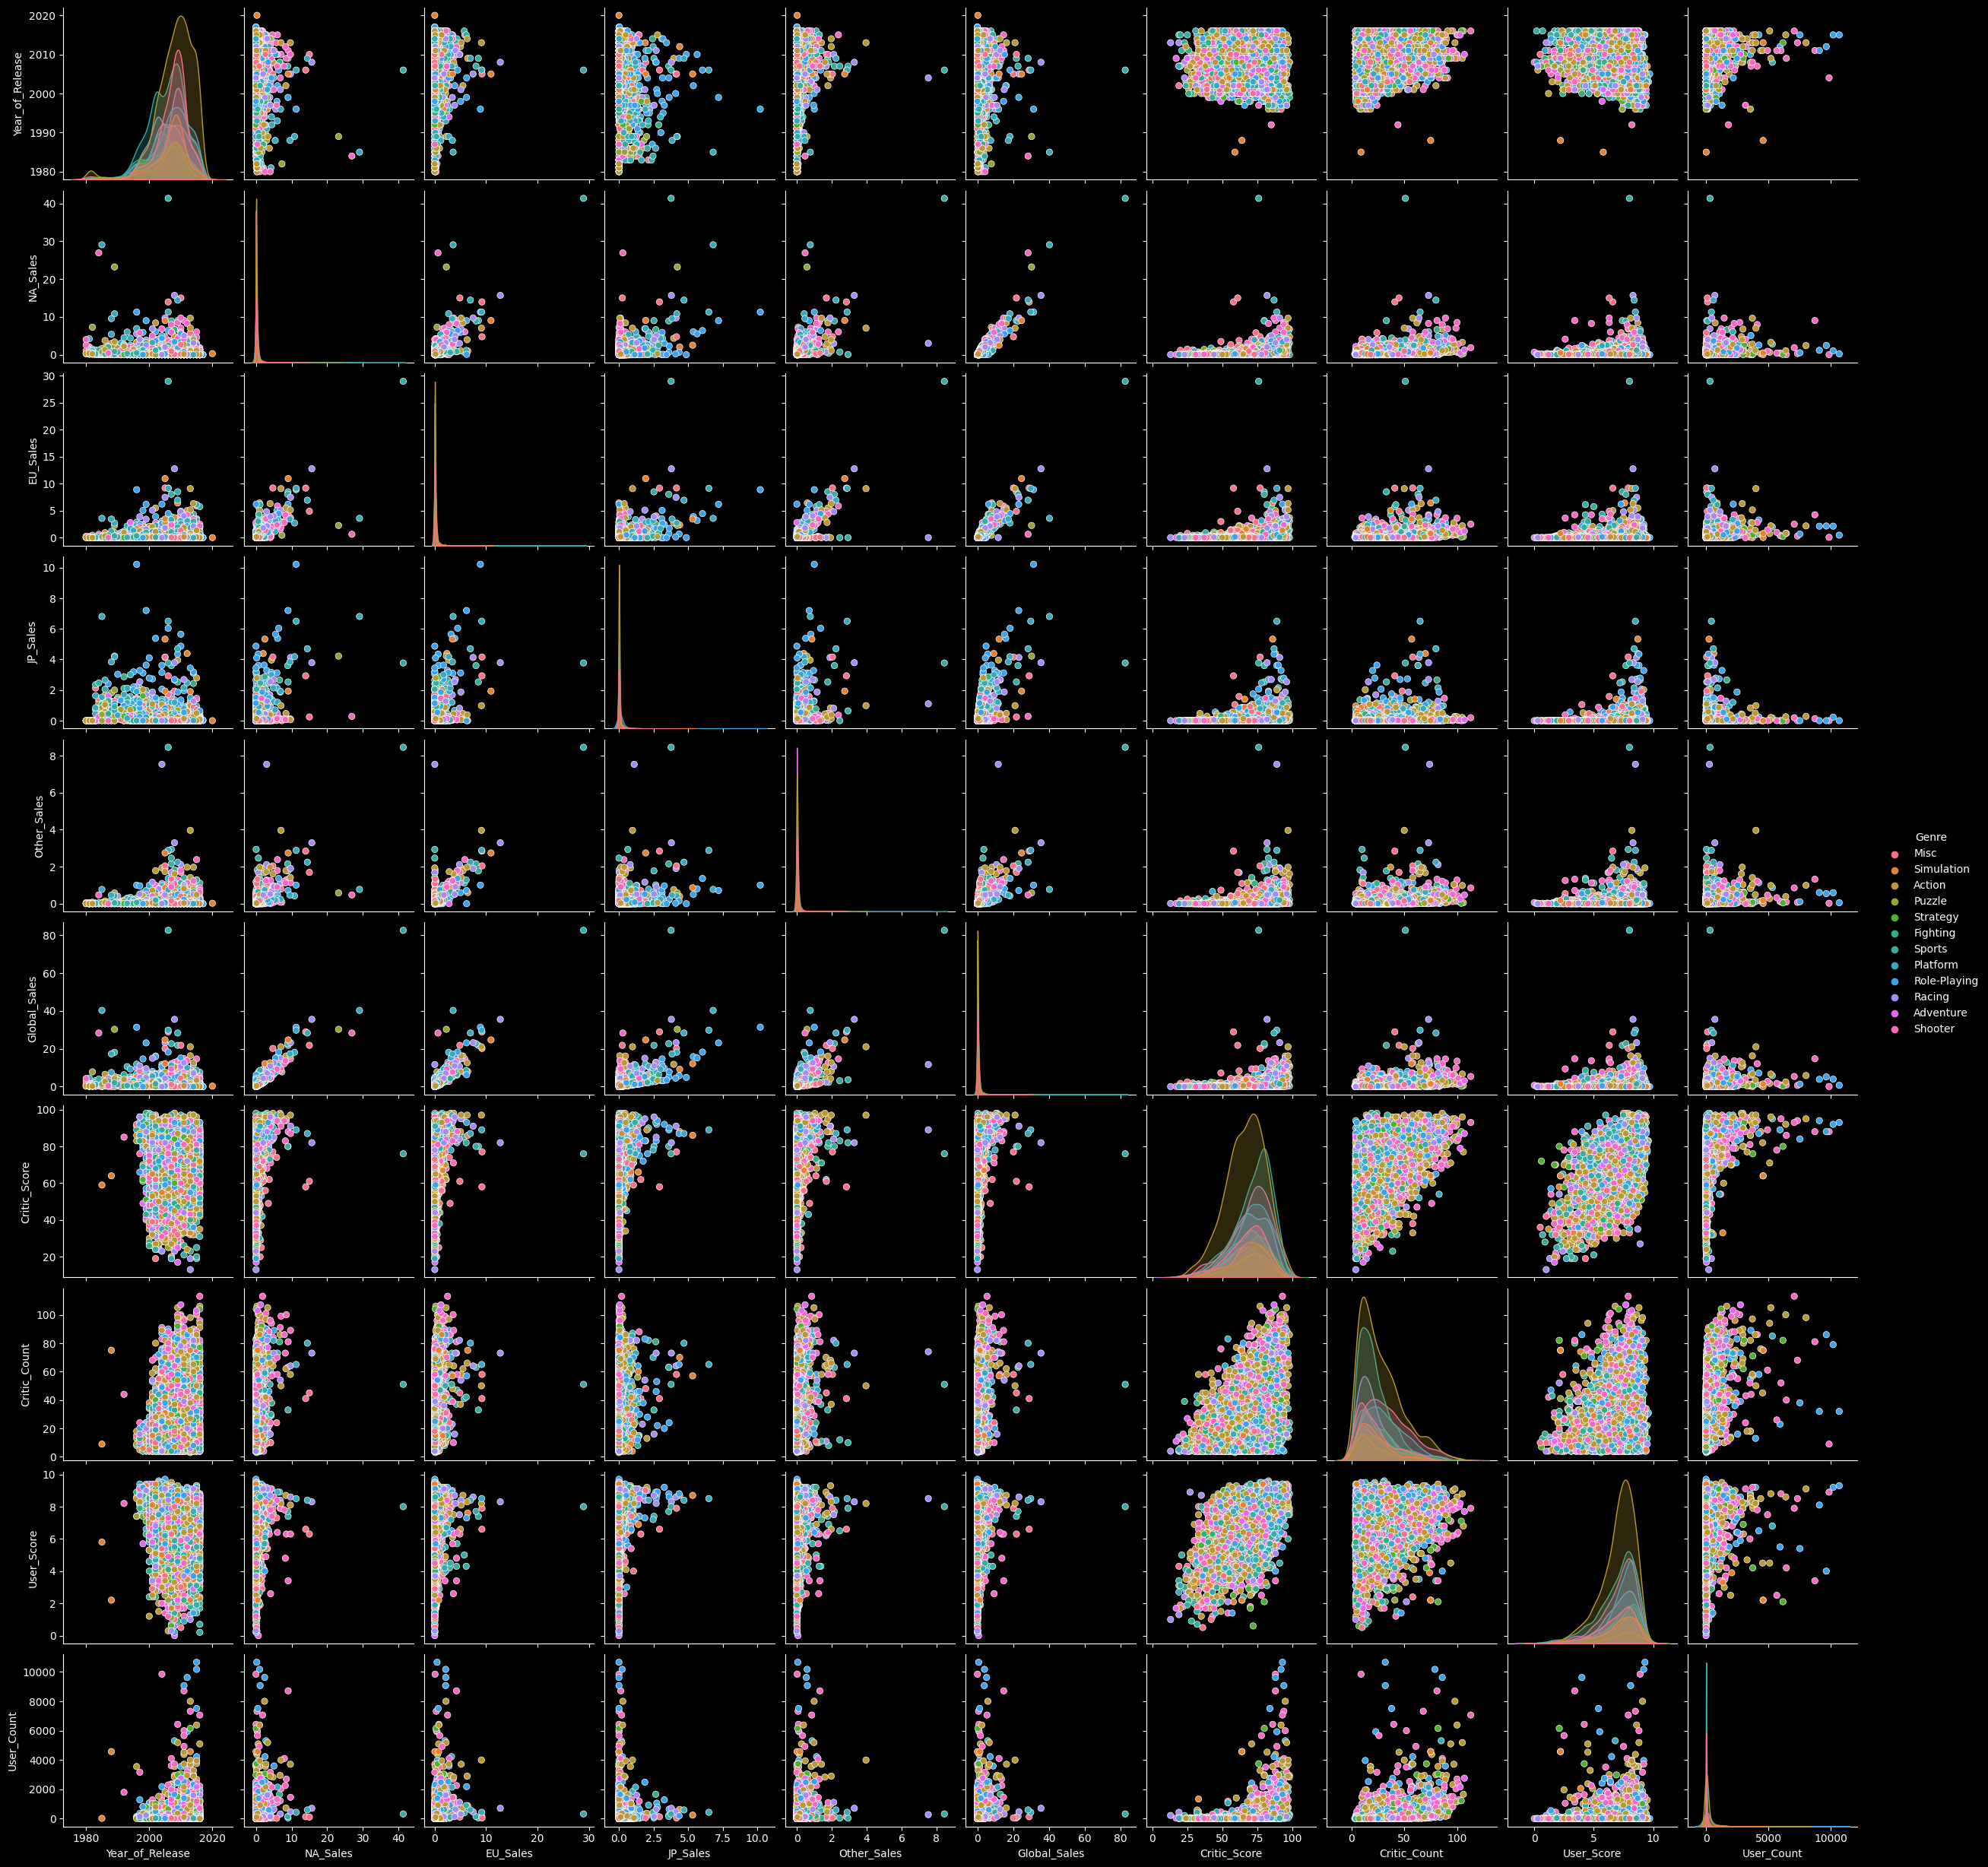

In [7]:
sns.pairplot(df, hue='Genre')
plt.show()

In [8]:
# get numerical and categorical columns from the dataset
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

num_cols, cat_cols

(['Year_of_Release',
  'NA_Sales',
  'EU_Sales',
  'JP_Sales',
  'Other_Sales',
  'Global_Sales',
  'Critic_Score',
  'Critic_Count',
  'User_Score',
  'User_Count'],
 ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating'])

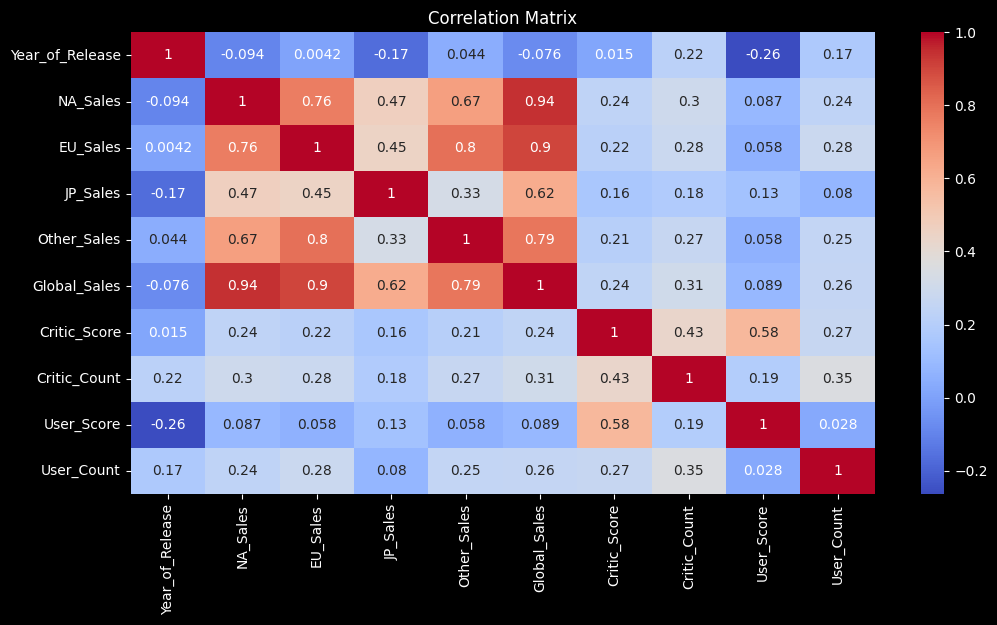

In [9]:
corr = df[num_cols].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
df.shape

(13373, 16)

In [11]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,13157.000000,13373.000000,13373.000000,13373.000000,13373.000000,13373.000000,6499.000000,6499.000000,6063.000000,6063.000000
mean,2006.507411,0.265515,0.147063,0.076707,0.047124,0.536657,68.962148,26.417757,7.121475,164.985816
std,5.880231,0.849229,0.523761,0.307777,0.174522,1.602215,13.960276,19.122553,1.505261,576.102433
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,11.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,82.000000
max,2020.000000,41.360000,28.960000,10.220000,8.450000,82.530000,98.000000,113.000000,9.700000,10665.000000


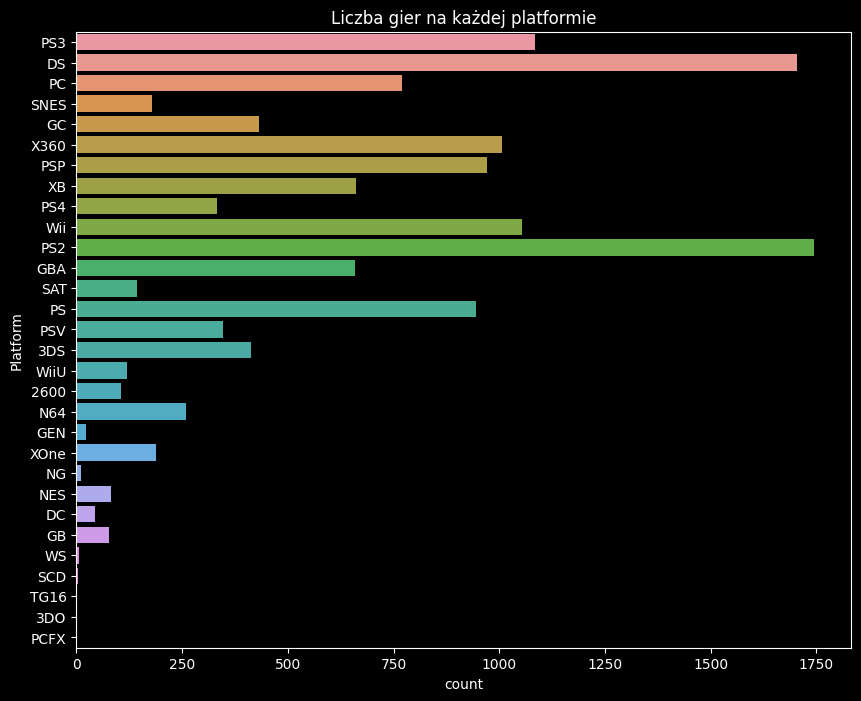

In [12]:
plt.figure(figsize=(10, 8))
sns.countplot(y='Platform', data=df)
plt.title('Liczba gier na każdej platformie')
plt.show()

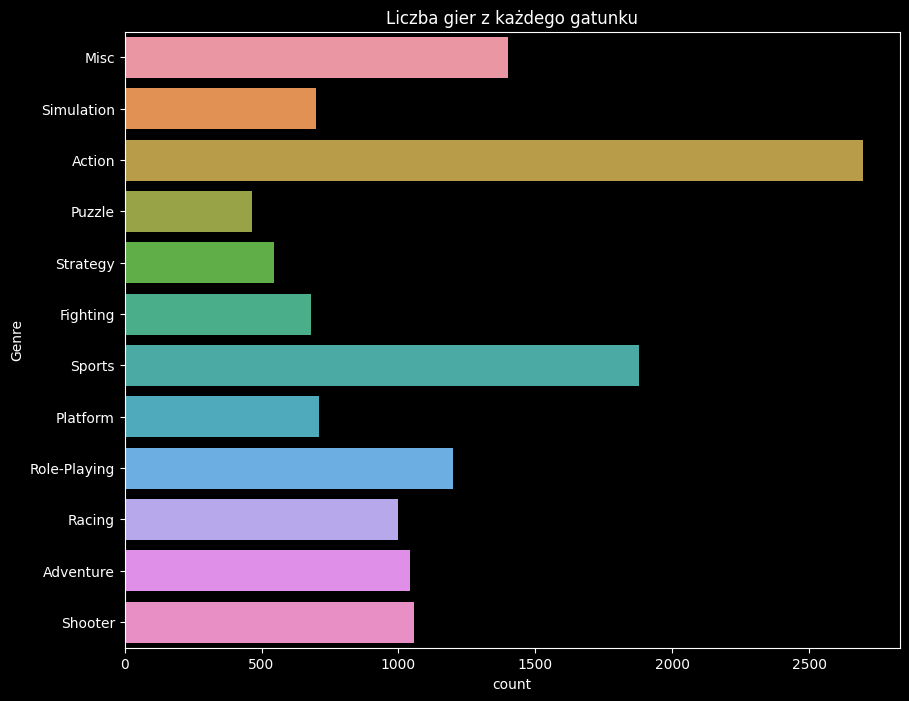

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(y='Genre', data=df)
plt.title('Liczba gier z każdego gatunku')
plt.show()

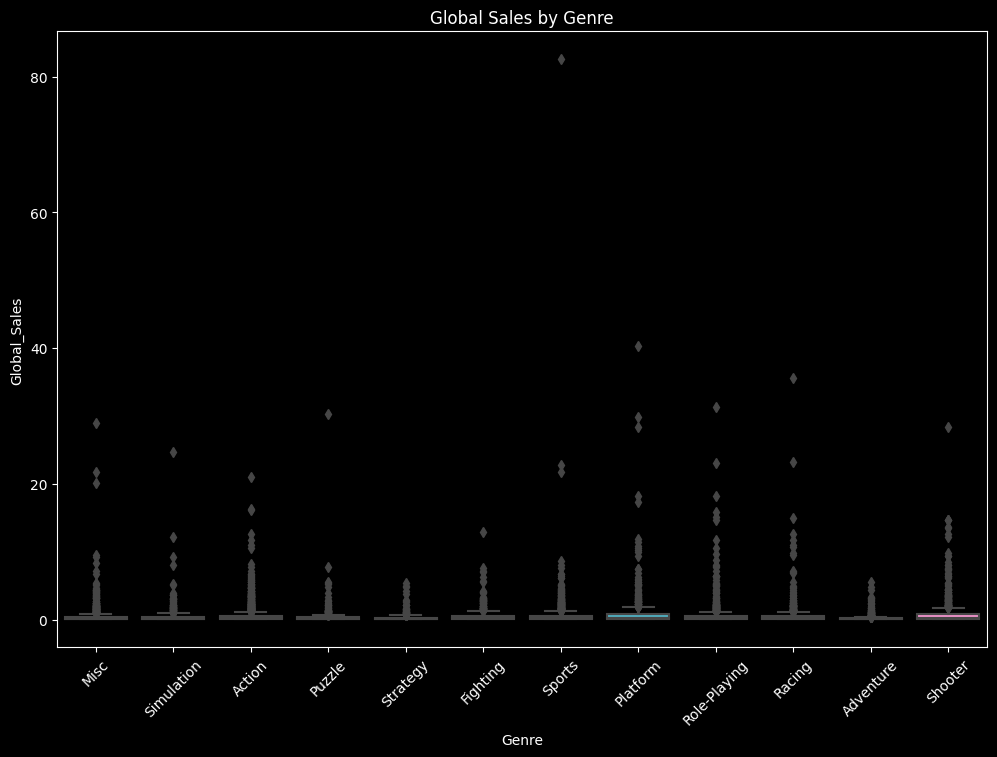

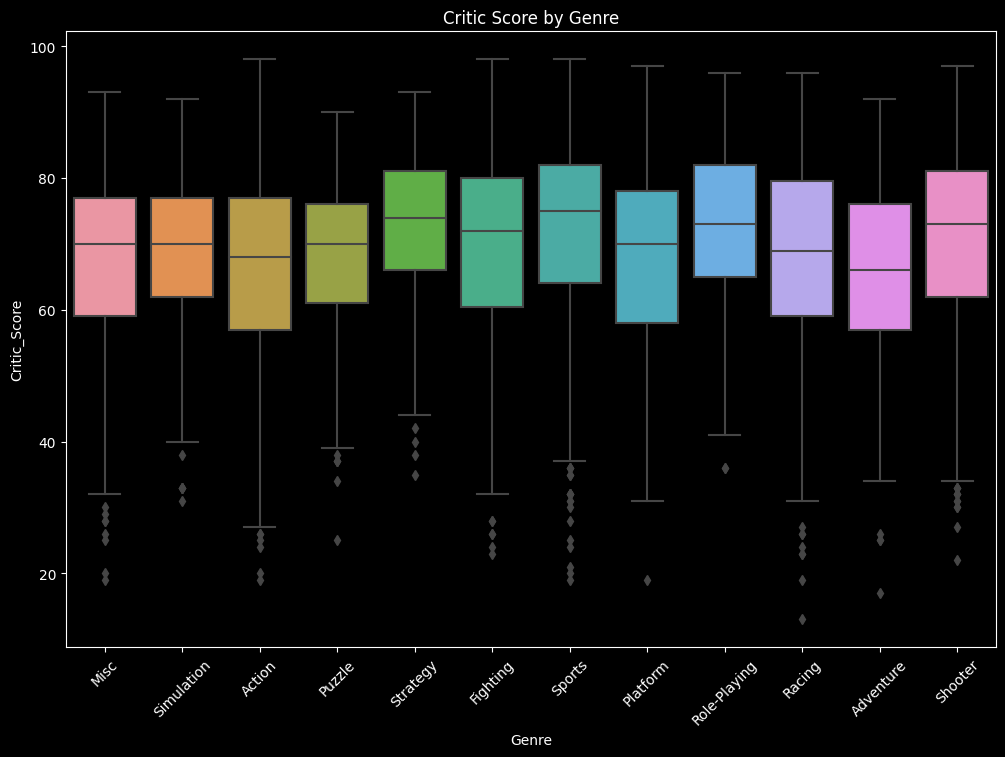

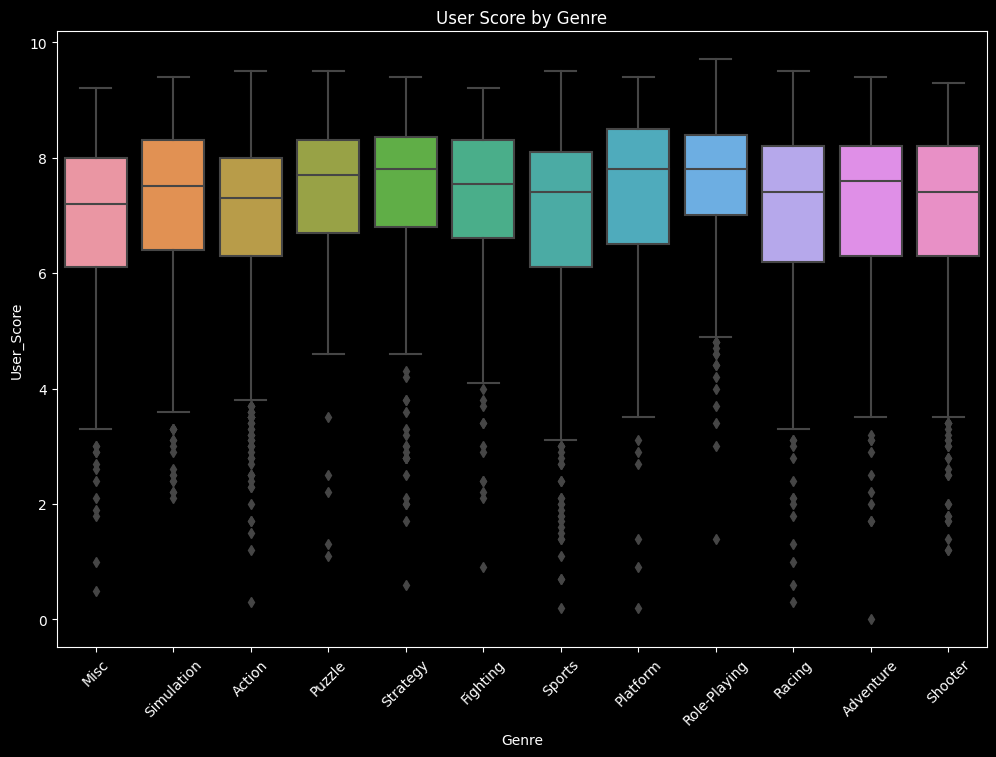

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Genre', y='Global_Sales', data=df)
plt.title('Global Sales by Genre')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Genre', y='Critic_Score', data=df)
plt.title('Critic Score by Genre')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Genre', y='User_Score', data=df)
plt.title('User Score by Genre')
plt.xticks(rotation=45)
plt.show()

## Wnioski EDA
Brakujące wartości:
- `Year_of_Release` ma 211 (1.6%) brakujących wartości
- `Critic_Score` ma 6868 (51.3%) brakujących wartości
- `Critic_Count` ma 6868 (51.3%) brakujących wartości
- `User_Score` ma 7310 (54.7%) brakujących wartości
- `User_Count` ma 7310 (54.7%) brakujących wartości
- `Developer` ma 5310 (39.7%) brakujących wartości
- `Rating` ma 5429 (40.6%) brakujących wartości


Rozkłady:
- `Other_Sales` is highly skewed (γ1 = 25.01499252)

Zera:
- `NA_Sales` ma 3588 (26.8%) zer
- `EU_Sales` ma 4719 (35.3%) zer
- `JP_Sales` ma 8440 (63.1%) zer
- `Other_Sales` ma 5317 (39.8%) zer

### Jakie podjąć kroki?
- Usunięcie wierszy z brakującymi wartościami w kolumnie `Year_of_Release`, bo jest to tylko 1.6% danych.
- Uzupełnienie reszty danych, bo brakujące wartości stanowią dużą część zbioru.

In [15]:
print(f'Wielkość przed: {df.shape[0]}')
df.dropna(subset=['Year_of_Release'], inplace=True)
print(f'Wielkość po: {df.shape[0]}')

Wielkość przed: 13373
Wielkość po: 13157


In [16]:
class FillMissing(BaseEstimator, TransformerMixin):
    def __init__(self, fill_values=None, dropna_columns=None):
        if fill_values is None:
            self.fill_values = {
                'Critic_Score':      ('mean', None),
                'Critic_Count':      ('mean', None),
                'User_Score':        ('mean', None),
                'User_Count':        ('mean', None),
                'Developer':         ('constant', 'Unknown'),
                'Rating':            ('constant', 'Not Rated')
            }
        else:
            self.fill_values = fill_values
        self.dropna_columns = dropna_columns if dropna_columns is not None else []

    def fit(self, X, y=None):
        self.statistics_ = {}
        for col, (strategy, value) in self.fill_values.items():
            if strategy == 'median':
                self.statistics_[col] = X[col].median()
            elif strategy == 'mean':
                self.statistics_[col] = X[col].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
    
        if self.dropna_columns:
            X_copy.dropna(subset=self.dropna_columns, inplace=True)
        
        for col, (strategy, fill_value) in self.fill_values.items():
            if strategy == 'median' or strategy == 'mean':
                X_copy[col] = X_copy[col].fillna(self.statistics_[col])
            elif strategy == 'constant':
                X_copy[col] = X_copy[col].fillna(fill_value)
        
        return X_copy

In [17]:
num_cols = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 
            'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
cat_cols = ['Platform', 'Rating', 'Developer']

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

In [19]:
pipeline = Pipeline(steps=[
    ('fill_missing', FillMissing()),
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=10, min_samples_split=5, min_samples_leaf=2))
])

In [20]:
X_train = train_data.drop('Genre', axis=1)
y_train = train_data['Genre']
X_test = test_data.drop('Genre', axis=1)
y_test = test_data['Genre']

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Uruchomienie modelu bazowego - drzewo decyzyjne

In [21]:
pipeline = Pipeline([
    ('fill_missing', FillMissing()),
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

results = {}
classification_reports = {}

In [22]:
y_train_pred = cross_val_predict(pipeline, X_train, y_train_encoded, cv=5)
train_report = classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
classification_reports['DecisionTree'] = train_report
print('Train report:')
print(classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))

Train report:
              precision    recall  f1-score   support

      Action       0.34      0.44      0.38      2696
   Adventure       0.27      0.29      0.28      1042
    Fighting       0.16      0.14      0.15       679
        Misc       0.27      0.28      0.28      1400
    Platform       0.18      0.16      0.17       711
      Puzzle       0.16      0.11      0.13       464
      Racing       0.18      0.12      0.15       999
Role-Playing       0.27      0.22      0.25      1200
     Shooter       0.28      0.23      0.26      1058
  Simulation       0.19      0.11      0.14       699
      Sports       0.35      0.46      0.40      1878
    Strategy       0.19      0.08      0.11       547

    accuracy                           0.28     13373
   macro avg       0.24      0.22      0.22     13373
weighted avg       0.27      0.28      0.27     13373



In [23]:
pipeline.fit(X_train, y_train_encoded)
y_test_pred = pipeline.predict(X_test)
test_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
results['DecisionTree'] = test_report
print('Test report:')
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Test report:
              precision    recall  f1-score   support

      Action       0.36      0.45      0.40       674
   Adventure       0.26      0.34      0.29       261
    Fighting       0.21      0.25      0.23       170
        Misc       0.29      0.29      0.29       350
    Platform       0.24      0.21      0.22       177
      Puzzle       0.23      0.12      0.16       116
      Racing       0.18      0.16      0.17       250
Role-Playing       0.28      0.21      0.24       300
     Shooter       0.31      0.26      0.28       265
  Simulation       0.26      0.16      0.20       175
      Sports       0.37      0.39      0.38       470
    Strategy       0.26      0.15      0.19       136

    accuracy                           0.30      3344
   macro avg       0.27      0.25      0.25      3344
weighted avg       0.29      0.30      0.29      3344



## Modelowanie zespołów klasyfikatorów

In [24]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "HbGBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

In [25]:
for name, model in models.items():
    pipeline = Pipeline([
        ('fill_missing', FillMissing()),
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Trening modelu
    y_train_pred = cross_val_predict(pipeline, X_train, y_train_encoded, cv=5)
    
    # Raport klasyfikacji 
    train_report = classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
    classification_reports[name] = train_report
    print(f"{name} Training Classification Report:")
    print(classification_report(y_train_encoded, y_train_pred, target_names=label_encoder.classes_))
    
    # Dopasowanie modelu
    pipeline.fit(X_train, y_train_encoded)
    
    # Generowanie prognoz na zbiorze testowym
    y_test_pred = pipeline.predict(X_test)
    
    # Raport klasyfikacji na zbiorze testowym
    test_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
    results[name] = test_report
    print(f"{name} Test Classification Report:")
    print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))
    
    print('\n\n#####################################################\n')

Random Forest Training Classification Report:
              precision    recall  f1-score   support

      Action       0.40      0.60      0.48      2696
   Adventure       0.36      0.28      0.31      1042
    Fighting       0.37      0.21      0.27       679
        Misc       0.36      0.33      0.35      1400
    Platform       0.30      0.19      0.23       711
      Puzzle       0.24      0.15      0.19       464
      Racing       0.37      0.25      0.30       999
Role-Playing       0.38      0.35      0.36      1200
     Shooter       0.42      0.36      0.39      1058
  Simulation       0.32      0.21      0.25       699
      Sports       0.43      0.58      0.49      1878
    Strategy       0.28      0.19      0.23       547

    accuracy                           0.38     13373
   macro avg       0.35      0.31      0.32     13373
weighted avg       0.37      0.38      0.37     13373

Random Forest Test Classification Report:
              precision    recall  f1-score  

In [26]:
print("Results:")
results_df = pd.DataFrame(results).T
results_df

Results:


,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,accuracy,macro avg,weighted avg
DecisionTree,"{'precision': 0.35605170387779084, 'recall': 0...","{'precision': 0.2571428571428571, 'recall': 0....","{'precision': 0.21105527638190955, 'recall': 0...","{'precision': 0.2853107344632768, 'recall': 0....","{'precision': 0.23717948717948717, 'recall': 0...","{'precision': 0.22950819672131148, 'recall': 0...","{'precision': 0.1759656652360515, 'recall': 0....","{'precision': 0.28444444444444444, 'recall': 0...","{'precision': 0.30837004405286345, 'recall': 0...","{'precision': 0.25925925925925924, 'recall': 0...","{'precision': 0.3665338645418327, 'recall': 0....","{'precision': 0.2564102564102564, 'recall': 0....",0.297249,"{'precision': 0.268935982475945, 'recall': 0.2...","{'precision': 0.2915642646885799, 'recall': 0...."
Random Forest,"{'precision': 0.3949416342412451, 'recall': 0....","{'precision': 0.3783783783783784, 'recall': 0....","{'precision': 0.415929203539823, 'recall': 0.2...","{'precision': 0.3684210526315789, 'recall': 0....","{'precision': 0.30701754385964913, 'recall': 0...","{'precision': 0.28378378378378377, 'recall': 0...","{'precision': 0.42857142857142855, 'recall': 0...","{'precision': 0.39453125, 'recall': 0.33666666...","{'precision': 0.4017857142857143, 'recall': 0....","{'precision': 0.4188034188034188, 'recall': 0....","{'precision': 0.4664429530201342, 'recall': 0....","{'precision': 0.35294117647058826, 'recall': 0...",0.401017,"{'precision': 0.3842956281321452, 'recall': 0....","{'precision': 0.39604007418627046, 'recall': 0..."
HbGBoosting,"{'precision': 0.4268689057421452, 'recall': 0....","{'precision': 0.4026548672566372, 'recall': 0....","{'precision': 0.38823529411764707, 'recall': 0...","{'precision': 0.35279805352798055, 'recall': 0...","{'precision': 0.3893805309734513, 'recall': 0....","{'precision': 0.25301204819277107, 'recall': 0...","{'precision': 0.3695652173913043, 'recall': 0....","{'precision': 0.35766423357664234, 'recall': 0...","{'precision': 0.39732142857142855, 'recall': 0...","{'precision': 0.3763440860215054, 'recall': 0....","{'precision': 0.423861852433281, 'recall': 0.5...","{'precision': 0.34065934065934067, 'recall': 0...",0.394438,"{'precision': 0.3731971548720112, 'recall': 0....","{'precision': 0.38784011427959536, 'recall': 0..."
XGBoost,"{'precision': 0.4486486486486487, 'recall': 0....","{'precision': 0.42735042735042733, 'recall': 0...","{'precision': 0.5543478260869565, 'recall': 0....","{'precision': 0.3804878048780488, 'recall': 0....","{'precision': 0.3828125, 'recall': 0.276836158...","{'precision': 0.3333333333333333, 'recall': 0....","{'precision': 0.5548780487804879, 'recall': 0....","{'precision': 0.4166666666666667, 'recall': 0....","{'precision': 0.5353535353535354, 'recall': 0....","{'precision': 0.4716981132075472, 'recall': 0....","{'precision': 0.4266263237518911, 'recall': 0....","{'precision': 0.42857142857142855, 'recall': 0...",0.440191,"{'precision': 0.44673122138574767, 'recall': 0...","{'precision': 0.4469789017226824, 'recall': 0...."
LightGBM,"{'precision': 0.42360379346680715, 'recall': 0...","{'precision': 0.4008810572687225, 'recall': 0....","{'precision': 0.4631578947368421, 'recall': 0....","{'precision': 0.3524804177545692, 'recall': 0....","{'precision': 0.3870967741935484, 'recall': 0....","{'precision': 0.21333333333333335, 'recall': 0...","{'precision': 0.37, 'recall': 0.296, 'f1-score...","{'precision': 0.35793357933579334, 'recall': 0...","{'precision': 0.4055299539170507, 'recall': 0....","{'precision': 0.3333333333333333, 'recall': 0....","{'precision': 0.4345718901453958, 'recall': 0....","{'precision': 0.39473684210526316, 'recall': 0...",0.397727,"{'precision': 0.3780549057992216, 'recall': 0....","{'precision': 0.3914828171587301, 'recall': 0...."
CatBoost,"{'precision': 0.40988372093023256, 'recall': 0...","{'precision': 0.38288288288288286, 'recall': 0...","{'precisio

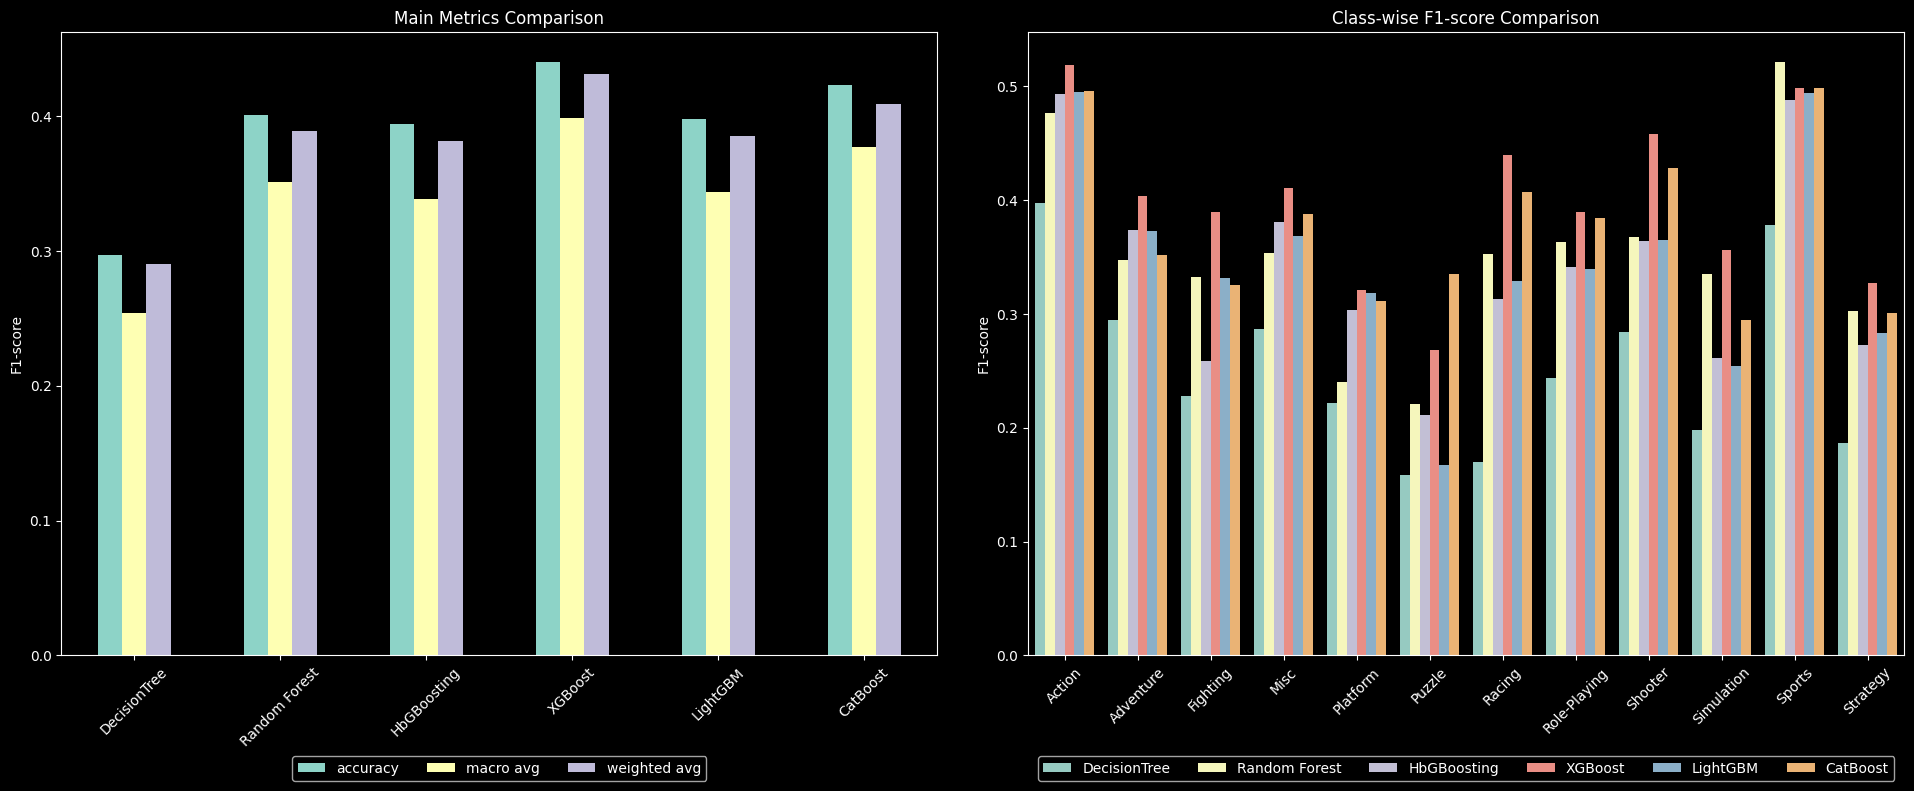

In [27]:
def get_and_plot_metrics(results_df):
    
    # Wyodrębnienie głównych metryk (accuracy, macro avg, weighted avg)
    main_metrics = results_df[['accuracy', 'macro avg', 'weighted avg']].map(lambda x: x['f1-score'] if isinstance(x, dict) else x)

    # Wyodrębnienie metryk dla poszczególnych klas
    class_metrics = results_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1).map(lambda x: x['f1-score'] if isinstance(x, dict) else x)
    class_metrics = class_metrics.T
    class_metrics['Class'] = class_metrics.index
    class_metrics = class_metrics.melt(id_vars='Class', var_name='Model', value_name='F1-score')
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    main_metrics.plot(kind='bar', ax=plt.gca())
    plt.title('Main Metrics Comparison')
    plt.ylabel('F1-score')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Class', y='F1-score', hue='Model', data=class_metrics, ax=plt.gca())
    plt.title('Class-wise F1-score Comparison')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    
    plt.tight_layout()
    plt.show()

get_and_plot_metrics(results_df)

# Zadanie 3 - Badanie hiperparametrów XGBoost Classifier

In [28]:
def objective(trial):
    param = {
        'max_depth':        trial.suggest_int('max_depth', 3, 15),
        'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators':     trial.suggest_int('n_estimators', 100, 1000),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda':           trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha':            trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    pipeline = Pipeline([
        ('fill_missing', FillMissing()),
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ])

    pipeline.fit(X_train, y_train_encoded)
    preds = pipeline.predict(X_test)
    # accuracy = accuracy_score(y_test_encoded, preds)
    f1_score_macro = f1_score(y_test_encoded, preds, average='macro')

    return f1_score_macro

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-24 15:13:01,667] A new study created in memory with name: no-name-a7309b2e-088a-48e3-a126-b557dee2bb18
[I 2024-06-24 15:14:51,435] Trial 0 finished with value: 0.29710372757376974 and parameters: {'max_depth': 9, 'learning_rate': 0.08958156575296931, 'n_estimators': 957, 'subsample': 0.5000674088560304, 'colsample_bytree': 0.8930218759948316, 'min_child_weight': 7, 'lambda': 0.608601262766468, 'alpha': 7.03821097410593e-08}. Best is trial 0 with value: 0.29710372757376974.
[I 2024-06-24 15:15:51,634] Trial 1 finished with value: 0.3509621140269268 and parameters: {'max_depth': 7, 'learning_rate': 0.03061832735589163, 'n_estimators': 889, 'subsample': 0.8965294807170436, 'colsample_bytree': 0.8431442316325428, 'min_child_weight': 7, 'lambda': 1.023165981398632e-06, 'alpha': 6.411019867300327e-06}. Best is trial 1 with value: 0.3509621140269268.
[I 2024-06-24 15:16:12,084] Trial 2 finished with value: 0.4105186653681421 and parameters: {'max_depth': 5, 'learning_rate': 0.04549

In [29]:
# Wyświetlenie najlepszych parametrów
print('Najlepsze hiperparametry:', study.best_params)
print('Najlepsze wyniki f1:', study.best_value)

# Run 1.
#  Najlepsze hiperparametry: 
    # {'max_depth': 3, 'learning_rate': 0.12888468190639749, 'n_estimators': 841, 
    # 'subsample': 0.8196992305521583, 'colsample_bytree': 0.6432278162080207, 
    # 'min_child_weight': 1, 'lambda': 1.5772510918465553e-08, 'alpha': 0.0553285291239376}
# Najlepsze wyniki f1: 0.4226192645892544

Najlepsze hiperparametry: {'max_depth': 4, 'learning_rate': 0.152545150025373, 'n_estimators': 320, 'subsample': 0.92640391328353, 'colsample_bytree': 0.9675641816032142, 'min_child_weight': 1, 'lambda': 0.27297894585950866, 'alpha': 2.2400400637818228e-05}
Najlepsze wyniki f1: 0.42006432053576565


In [30]:
# Wytrenowanie modelu z najlepszymi hiperparametrami
best_params = study.best_params
pipeline = Pipeline([
    ('fill_missing', FillMissing()),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Trenowanie pipeline na danych treningowych
pipeline.fit(X_train, y_train_encoded)

# Prognozowanie i ocena modelu na zbiorze testowym
y_test_pred = pipeline.predict(X_test)
test_f1_score = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test F1: {test_f1_score}")

print("Rapoort klasyfikacji:")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Test F1: 0.45394736842105265
Rapoort klasyfikacji:
              precision    recall  f1-score   support

      Action       0.45      0.61      0.52       674
   Adventure       0.40      0.38      0.39       261
    Fighting       0.54      0.33      0.41       170
        Misc       0.39      0.46      0.42       350
    Platform       0.44      0.29      0.35       177
      Puzzle       0.39      0.30      0.34       116
      Racing       0.58      0.38      0.46       250
Role-Playing       0.42      0.36      0.39       300
     Shooter       0.59      0.43      0.50       265
  Simulation       0.54      0.30      0.38       175
      Sports       0.45      0.62      0.52       470
    Strategy       0.44      0.29      0.35       136

    accuracy                           0.45      3344
   macro avg       0.47      0.40      0.42      3344
weighted avg       0.46      0.45      0.45      3344



# Zadanie 4

## Ograniczenia monotoniczności

In [31]:
best_params = study.best_params
monotonic_constraints = "(0, 0, 0, 0, 1, 1, 0, 1, 0, 0)"
best_params['monotone_constraints'] = monotonic_constraints

pipeline = Pipeline([
    ('fill_missing', FillMissing()),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Trenowanie pipeline na danych treningowych
pipeline.fit(X_train, y_train_encoded)

# Prognozowanie i ocena modelu na zbiorze testowym
y_test_pred = pipeline.predict(X_test)
test_f1_score = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test F1: {test_f1_score}")

print("Rapoort klasyfikacji:")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Test F1: 0.45753588516746413
Rapoort klasyfikacji:
              precision    recall  f1-score   support

      Action       0.45      0.63      0.53       674
   Adventure       0.40      0.38      0.39       261
    Fighting       0.53      0.29      0.38       170
        Misc       0.41      0.45      0.43       350
    Platform       0.44      0.29      0.35       177
      Puzzle       0.39      0.30      0.34       116
      Racing       0.53      0.38      0.45       250
Role-Playing       0.43      0.38      0.41       300
     Shooter       0.57      0.43      0.49       265
  Simulation       0.55      0.31      0.39       175
      Sports       0.46      0.62      0.53       470
    Strategy       0.48      0.29      0.37       136

    accuracy                           0.46      3344
   macro avg       0.47      0.40      0.42      3344
weighted avg       0.47      0.46      0.45      3344



In [32]:
best_params = study.best_params
monotonic_constraints = "(0, 0, 0, 0, 1, 1, 0, 1, 0, 0)"
best_params['monotone_constraints'] = monotonic_constraints
best_params['objective'] = 'mutli:softprob'

pipeline = Pipeline([
    ('fill_missing', FillMissing()),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# Trenowanie pipeline na danych treningowych
pipeline.fit(X_train, y_train_encoded)

# Prognozowanie i ocena modelu na zbiorze testowym
y_test_pred = pipeline.predict(X_test)
test_f1_score = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test F1: {test_f1_score}")

print("Rapoort klasyfikacji:")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Test F1: 0.45753588516746413
Rapoort klasyfikacji:
              precision    recall  f1-score   support

      Action       0.45      0.63      0.53       674
   Adventure       0.40      0.38      0.39       261
    Fighting       0.53      0.29      0.38       170
        Misc       0.41      0.45      0.43       350
    Platform       0.44      0.29      0.35       177
      Puzzle       0.39      0.30      0.34       116
      Racing       0.53      0.38      0.45       250
Role-Playing       0.43      0.38      0.41       300
     Shooter       0.57      0.43      0.49       265
  Simulation       0.55      0.31      0.39       175
      Sports       0.46      0.62      0.53       470
    Strategy       0.48      0.29      0.37       136

    accuracy                           0.46      3344
   macro avg       0.47      0.40      0.42      3344
weighted avg       0.47      0.46      0.45      3344



In [ ]:
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# # Definicja niestandardowej funkcji straty
# def custom_loss(y_true, y_pred):
#     grad = y_pred - y_true
#     hess = y_pred * (1 - y_pred)
#     grad[y_true == 1] *= 2
#     return grad, hess

# def xgb_custom_loss(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     grad, hess = custom_loss(y_true, y_pred)
#     return grad, hess

# # Przygotowanie danych do DMatrix
# dtrain = DMatrix(X_train_transformed, label=y_train_encoded)
# dtest = DMatrix(X_test_transformed, label=y_test_encoded)

# # Najlepsze hiperparametry z Optuna
# best_params = study.best_params
# best_params['eval_metric'] = 'logloss'

# # Trenowanie modelu XGBoost z niestandardową funkcją straty
# bst = train(best_params, dtrain, num_boost_round=100, obj=xgb_custom_loss)

# # Prognozowanie i ocena modelu na zbiorze testowym
# y_test_pred = np.round(bst.predict(dtest))
# test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
# print(f"Test Accuracy with custom loss: {test_accuracy}")

# print("Classification Report with custom loss:")
# print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))
